In [1]:
import json

# Load training labels
train_pos_samples = []
train_neg_samples = []
with open('attributes_labels/energy_train.txt', 'r') as fin:
    for line in fin:
        snippet = json.loads(line)
        if snippet['label'] == 1:
            train_pos_samples.append([snippet['id'], snippet['offset']])
        else:
            train_neg_samples.append([snippet['id'], snippet['offset']])

# Load testing labels
test_pos_samples = []
test_neg_samples = []
with open('attributes_labels/energy_test.txt', 'r') as fin:
    for line in fin:
        snippet = json.loads(line)
        if snippet['label'] == 1:
            test_pos_samples.append([snippet['id'], snippet['offset']])
        else:
            test_neg_samples.append([snippet['id'], snippet['offset']])

In [2]:
from alpr_extractor import ALPRExtractor

# Load ALPR extractor
extractor = ALPRExtractor()
extractor.load_model(path='pretrained_model/alpr')

INFO:tensorflow:Restoring parameters from pretrained_model/alpr


In [3]:
import numpy as np
from tqdm import tqdm

def get_spectrograms(samples):
    samples_spectrograms = []
    for s in tqdm(samples):
        samples_spectrograms.append(np.load('data/attributes_prediction_spectrograms/e_%s_%d.npy' % (s[0], s[1]))\
                              .reshape((1, 128, 512, 1)))
    samples_spectrograms = np.concatenate(samples_spectrograms, axis=0)
    return (samples_spectrograms + 2.0) / 2

def extract_features(samples_spectrograms, extractor=extractor, batch_size=16):
    num_batches = int(1 + (len(samples_spectrograms) - 1) / batch_size)
    features_output = []
    for step in tqdm(range(num_batches)):
        in_spectrograms = samples_spectrograms[step*batch_size:(step+1)*batch_size]
        features_output.append(extractor.forward(in_spectrograms))
    return np.concatenate(features_output, axis=0)

train_pos_samples_spectrograms = get_spectrograms(train_pos_samples)
train_neg_samples_spectrograms = get_spectrograms(train_neg_samples)
test_pos_samples_spectrograms = get_spectrograms(test_pos_samples)
test_neg_samples_spectrograms = get_spectrograms(test_neg_samples)

train_pos_samples_features = extract_features(train_pos_samples_spectrograms)
train_neg_samples_features = extract_features(train_neg_samples_spectrograms)
test_pos_samples_features = extract_features(test_pos_samples_spectrograms)
test_neg_samples_features = extract_features(test_neg_samples_spectrograms)

100%|██████████| 17/17 [00:00<00:00, 69.17it/s]


In [4]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

train_features = np.concatenate((train_pos_samples_features, 
                           train_neg_samples_features), axis=0)
train_labels = np.array([1]*len(train_pos_samples) + \
                        [0]*len(train_neg_samples))

best_perform = 0
best_C = 0.0001
for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    lr_model = LR(C=C)
    perform = np.mean(cross_val_score(lr_model, train_features, train_labels, cv=5))
    if perform > best_perform:
        best_perform = perform
        best_C = C

model = LR(C=best_C)
model.fit(train_features, train_labels)

test_features = np.concatenate((test_pos_samples_features, 
                                test_neg_samples_features), axis=0)
test_labels = np.array([1]*len(test_pos_samples) + \
                       [0]*len(test_neg_samples))
test_scores = model.decision_function(test_features)

# Accuracy and AUC
print('Accuracy:', model.score(test_features, test_labels))
print('AUC:', roc_auc_score(test_labels, test_scores))

Accuracy: 0.8981481481481481
AUC: 0.9500274348422497


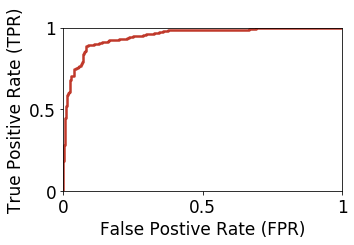

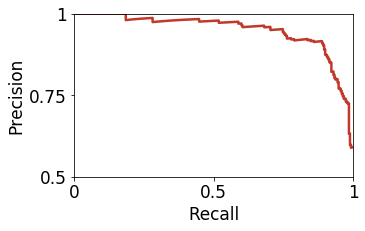

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# AUC curve and Precision-Recall curve
test_precision, test_recall, _ = precision_recall_curve(y_true=test_labels, probas_pred=test_scores)
test_fpr, test_tpr, _ = roc_curve(y_true=test_labels, y_score=test_scores)

plt.figure(figsize=(5, 3))
plt.plot(test_fpr, test_tpr, color='#c0392b', linewidth=2.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=17)
plt.yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=17)
plt.xlabel("False Postive Rate (FPR)", fontsize=17)
plt.ylabel("True Positive Rate (TPR)", fontsize=17)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(test_recall, test_precision, color='#c0392b', linewidth=2.5)
plt.xlim([0, 1])
plt.ylim([0.5, 1])
plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=17)
plt.yticks([0.5, 0.75, 1.0], [0.5, 0.75, 1], fontsize=17)
plt.xlabel("Recall", fontsize=17)
plt.ylabel("Precision", fontsize=17)
plt.show()